In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install ct-counterfactuals
!pip install git+https://github.com/ieee8023/captum 

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import skimage
import glob
import captum
import latentshift
import ct_counterfactuals as ct_cf

/tmp/ipykernel_12994/3824702743.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cuda'

In [4]:
model = ct_cf.classifiers.lungmask.LungMaskSegmenter(download=True).to(device)

In [5]:
ae = ct_cf.ae.VQGAN(
    weights='2023-12-25T10-26-40_ct2_vqgan256_sddd',
    download=True,
    #cache_dir='/home/users/joecohen/scratch/cache/'
).to(device)

Working with z of shape (1, 256, 4, 4) = 4096 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
!mkdir volumes
!wget -q https://github.com/ieee8023/ct-counterfactuals/raw/main/volumes/TCIA-LCTSC-_RCCTPET_THORAX_CONTRAST_dag0_20080918110916_4268307088.nii.gz -O volumes/TCIA-LCTSC-_RCCTPET_THORAX_CONTRAST_dag0_20080918110916_4268307088.nii.gz

In [6]:
data = ct_cf.datasets.NIFTI_Dataset('volumes/', resolution=224)

In [7]:
img = data[0]['image'][None,...]
img.shape

torch.Size([1, 1, 224, 224, 134])

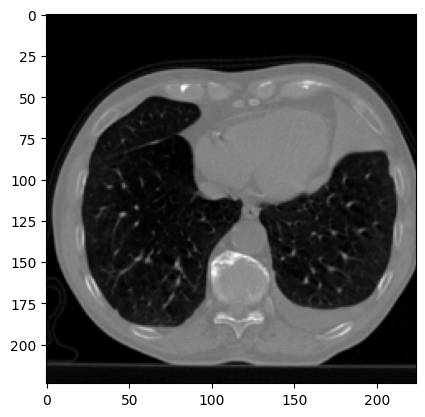

In [8]:
plt.imshow(img[0,0,:,:,45], cmap='gray');

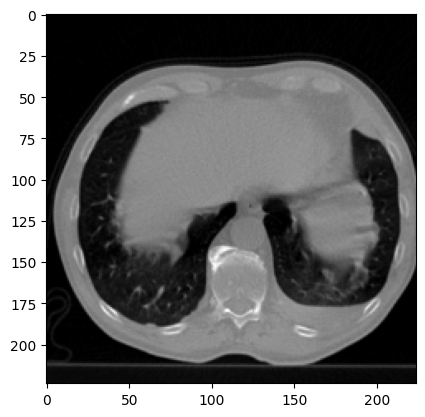

In [9]:
x = img[:,:,:,:,37]
x = torch.from_numpy(ct_cf.datasets.Resize(224)(x[0,0])[None,None])
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray');

In [10]:
z = ae.encode(x.to(device))

In [11]:
img2 = ae.decode(z)

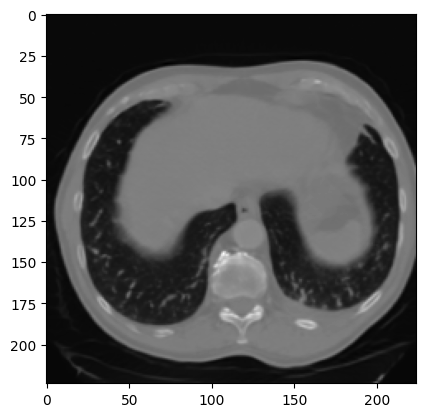

In [12]:
plt.imshow(img2[0][0].cpu().detach().numpy(), cmap='gray');

In [13]:
with torch.no_grad():
    out = model(img.to(device))

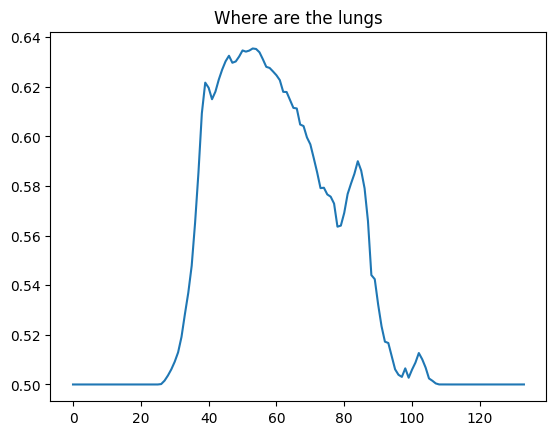

In [14]:
plt.plot(1-(out).cpu()[0][0].mean((0,1)));
plt.title('Where are the lungs');

In [15]:
out.shape

torch.Size([1, 3, 224, 224, 134])

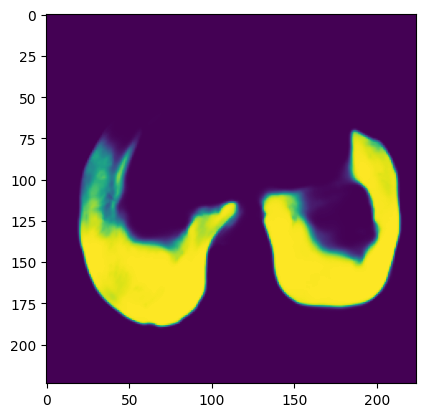

In [16]:
plt.imshow(1-out[0,0,...,37].cpu());

In [17]:
img_slice = img[...,37:38]

In [18]:
attr = captum.attr.LatentShift(
    latentshift.alignment.ModelWrapper(
    model, 
    target='No Lung', 
    adjustment=lambda x: 1-x.mean((2,3,4)), 
    rename_model='', sigmoid=False), 
    ct_cf.ae.SliceAEFull(ae,0,1),
)
output = attr.attribute(img_slice.to(device), target=0,
                        return_dicts = True,
                        apply_sigmoid = False,
                        search_max_steps = 600000,
                       )[0]

Shift: 0, Pred: 0.5572161078453064, pixel_diff: 0.0, sum*diff_pct: 981.2310791015625
Shift: -10.0, Pred: 0.5570235252380371, pixel_diff: 3.66827654838562, sum*diff_pct: 981.2310791015625
Shift: -21.0, Pred: 0.5568141937255859, pixel_diff: 7.707249164581299, sum*diff_pct: 981.2310791015625
Shift: -34.0, Pred: 0.5565673112869263, pixel_diff: 12.48629093170166, sum*diff_pct: 981.2310791015625
Shift: -48.0, Pred: 0.5563028454780579, pixel_diff: 17.637990951538086, sum*diff_pct: 981.2310791015625
Shift: -63.0, Pred: 0.5560195446014404, pixel_diff: 23.15729522705078, sum*diff_pct: 981.2310791015625
Shift: -80.0, Pred: 0.5557000637054443, pixel_diff: 29.410411834716797, sum*diff_pct: 981.2310791015625
Shift: -98.0, Pred: 0.5553638339042664, pixel_diff: 36.03288269042969, sum*diff_pct: 981.2310791015625
Shift: -118.0, Pred: 0.5549905300140381, pixel_diff: 43.3922119140625, sum*diff_pct: 981.2310791015625
Shift: -140.0, Pred: 0.5545833706855774, pixel_diff: 51.48509216308594, sum*diff_pct: 981.

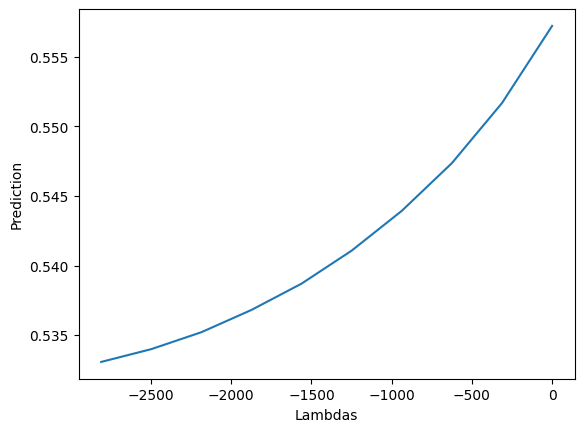

In [19]:
plt.plot(output['lambdas'],output['preds']);
plt.xlabel('Lambdas');
plt.ylabel('Prediction');

In [20]:
idx=0

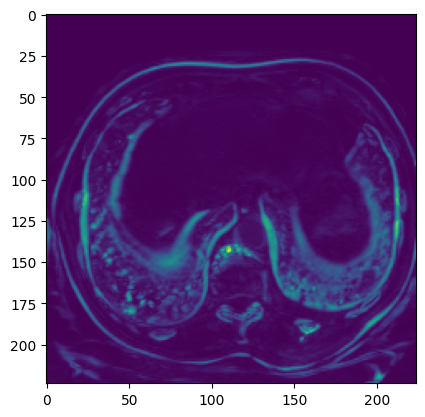

In [21]:
plt.imshow(output['heatmap'][0,:,:,idx]);

In [22]:
images = [output['generated_images'][i, :,:,:,idx] for i in range(len(output['generated_images']))]

In [23]:
latentshift.video_utils.generate_video({'generated_images':images, 'preds':output['preds']-np.min(output['preds'])}, "test", show_pred=True, watermark=False, cmap='gray', 
                                       extra_loops=0,
                                      ffmpeg_path='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg',
                                      resize=512)


/share/software/user/open/ffmpeg/5.0/bin/ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:512 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   20 fps=0.0 q=-1.0 Lsize=      49kB time=00:00:00.76 bitrate= 526.4kbits/s speed=3.73x    
